In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
'''Dynamic Programming, FCFS Simulated result'''
UB = 79115
dp = 61135
fcfs = 45564

In [5]:
'''Establish an aircraft'''
class aircraft:

    # Initialize aircraft
    def __init__(self):
        self.alpha = 1
        self.seat_capacity_L1 = 30*self.alpha
        self.seat_capacity_L2 = 50*self.alpha
        self.seat_capacity_L3 = 40*self.alpha
        self.seat_capacity = self.seat_capacity_L1+self.seat_capacity_L2+self.seat_capacity_L3
        self.seat_type = ['L1L', 'L1H', 'L2L', 'L2H', 'L3L', 'L3H']
        self.seat_price = {'L1L': 400, 'L1H': 800, 'L2L': 500, 'L2H': 1000, 'L3L': 300, 'L3H': 600}

In [6]:
''' Demand model from Balaiyan et al.'''
class demandmodel:
    
    # Initialize demand model
    def __init__(self):
        
        # inherent attributes from aircraft class
        self.aircraft = aircraft()
        self.seat_set = self.aircraft.seat_type
        self.seat_price = self.aircraft.seat_price
        
        # demand model parameters
        self.total_booking = 105
        self.market_share = 0.25
        self.gamma = 0.08426
        self.alpha = 0.001251
        self.beta = {'DFARE':-0.006, 'LOT3':-0.944}
        self.a = {'L1L':{'DFARE':400, 'LOT3':1},
                  'L1H':{'DFARE':800, 'LOT3':1},
                  'L2L':{'DFARE':500, 'LOT3':1},
                  'L2H':{'DFARE':1000, 'LOT3':1},
                  'L3L':{'DFARE':300, 'LOT3':1},
                  'L3H':{'DFARE':600, 'LOT3':1},
                 }
        self.fare_diff_avg = sum(self.seat_price.values()) / len(self.seat_price)
        for seat_type in self.a:
            self.a[seat_type]['DFARE'] = round(self.a[seat_type]['DFARE'] - self.fare_diff_avg, 2)

    # Calculate dm
    def dm(self):
        dm = self.total_booking/self.market_share
        return dm

    # Calcilate booking curve
    def booking_curve(self, RD2, RD1):
        booking_curve = math.exp(-self.gamma*RD2)-math.exp(-self.gamma*RD1)
        return booking_curve

    # find pj+1
    def find_pj1(self, seat):
        smaller_keys = [key for key in self.seat_price.keys() if key < seat]
        if smaller_keys:
            max_smaller_key = max(smaller_keys)
            pj1 = self.seat_price[max_smaller_key]
        else:
            pj1 = min(self.seat_price.values())
        return pj1

    # Multinomial logit model
    def mnl(self):
        choose_prob = {}
        value_dict = {}
        for seat in self.seat_set:
            result = {key: self.beta[key] * value for key, value in self.a[seat].items()}
            total = sum(result.values())
            value = math.exp(total)
            value_dict[seat] = value
        for seat in value_dict:
            exp_value = math.exp(value_dict[seat])
            choose_prob[seat] = exp_value / sum(math.exp(value) for value in value_dict.values())
        # print("mnl: ", choose_prob)
        return choose_prob

    # Calculate customer choice
    def customer_choice(self, seat_type):
        total_sum = 0
        choose_prob = self.mnl()
        min_key = min(self.seat_price, key=self.seat_price.get)
        p0 = self.seat_price[min_key]
        for seat in self.seat_set:
            pj = self.seat_price['L1L'] # 暫時寫這樣
            pj1 = self.seat_price['L2L'] # 暫時寫這樣
            # print('p0: ',p0 , 'p1: ', pj, 'pj1: ', pj1)
            sum_of_set = (math.exp(-self.alpha*(pj-p0))-math.exp(-self.alpha*(pj1-p0))) * choose_prob[seat_type] 
            # print('sum of set: ', sum_of_set)
            total_sum += sum_of_set
        return total_sum

    # Calculate demand
    def formulation(self, RD2, RD1):
        dm = self.dm()
        # print('dm',dm)
        booking_curve = self.booking_curve(RD2, RD1)
        # print('booking curve: ',booking_curve)
        BR_dict = {}
        
        for seat in self.seat_set:
            # print("calculate", seat, " ing...")
            customer_choice = self.customer_choice(seat)
            # print('customer choice', customer_choice)
            BR = dm * booking_curve * customer_choice
            BR_dict[seat] = BR
            # print(' seat: ', seat, ' predicted demand model from ', RD2,' to ', RD1, 'is', BR)
        # print("total demand: ", sum(BR_dict.values()))
        return BR_dict
    
    # Plot demand result
    def plot_demand(self):
        
        # Store calculated result
        every_rd = {seat: [] for seat in model.seat_set}  
        cumulative_demand = {seat: [] for seat in model.seat_set}  
        total_demand = {seat: 0 for seat in model.seat_set}  
        cumulative_total_demand_per_rd = []  # Store each RD cumulative demand

        # Calculate all RD demand
        cumulative_total_demand = 0  # Initialize cumulative demand
        for i in range(2, max_rd+1):
            # print('i: ', i)
            BR_results = model.formulation(i, i-1)  
            total_demand_rd = sum(BR_results.values())  # Calculate demand form all rd
            cumulative_total_demand += total_demand_rd  # update cumulative total deamnd
            cumulative_total_demand_per_rd.append(cumulative_total_demand)  # append cumulative total demand
            for seat, demand in BR_results.items():  
                every_rd[seat].append(demand) 
                total_demand[seat] += demand  
                cumulative_demand[seat].append(total_demand[seat])  
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, max_rd), cumulative_total_demand_per_rd, label='Total Demand')
        plt.xlabel('RD')
        plt.ylabel('Total Demand')
        plt.title('Total Demand Model')
        plt.legend()
        plt.xticks(range(0, max_rd, int(max_rd/10)))
        plt.grid(True)
        plt.show()

In [7]:
'''Action space'''
class AgentActionSpace:
    def __init__(self):
        self.action_list = list(range(64))
        self.n = len(self.action_list) 

    def sample(self):
        return np.random.choice(self.action_list)

    def contains(self, action):
        return action in self.action_list

In [8]:
'''Uniform distribution'''
class uniform_distribution:

    # Initialize parameters
    def __init__(self, total_demand, total_lambda):
        self.total_demand = total_demand
        self.total_lambda = total_lambda
        self.num_period = int(total_demand/total_lambda)
        self.prob = {'Bus1': 0.2, 'Bus2': 0.3, 'Leis1': 0.4, 'Leis2': 0.1}
    
    # Calculate lambda for each type of customer
    def calculate_lambda(self):
        lambda_list = []
        lambda_list.append(round(1-self.total_lambda, 2))
        for customer in self.prob:
            lambda_list.append(round(self.prob[customer] * self.total_lambda, 2)) 
        # print("lambda_list: ", lambda_list)
        return lambda_list

In [9]:
'''Establish Customer class'''
class Customer:

    ''' Initialization '''
    def __init__(self, total_demand, total_lambda):
        self.customer_type = {0: 'f', 1: 'Bus1', 2:'Bus2', 3:'Leis1', 4: 'Leis2'}
        self.num_customer_type = len(self.customer_type)
        self.customer_preference = {
            'f':{'L1L': False, 'L1H': False, 'L2L': False, 'L2H': False, 'L3L': False, 'L3H': False},
            'Bus1': {'L1L': False, 'L1H': True, 'L2L': False, 'L2H': True, 'L3L': False , 'L3H': True},
            'Bus2': {'L1L': True, 'L1H': False, 'L2L': True, 'L2H': False, 'L3L': True , 'L3H': False},
            'Leis1': {'L1L': True, 'L1H': True, 'L2L': True, 'L2H': True, 'L3L': True, 'L3H': True},
            'Leis2': {'L1L': True, 'L1H': True, 'L2L': True, 'L2H': True, 'L3L': True, 'L3H': True},
        } # consideration set
        self.preference_v = {
            'f':{'L1L': 0, 'L1H': 0, 'L2L': 0, 'L2H': False, 'L3L': False, 'L3H': False},
            'Bus1': {'L1L': 0, 'L1H': 5, 'L2L': 0, 'L2H': 10, 'L3L': 0 , 'L3H': 1},
            'Bus2': {'L1L': 5, 'L1H': 0, 'L2L': 1, 'L2H': 0, 'L3L': 10 , 'L3H': 0},
            'Leis1': {'L1L': 10, 'L1H': 8, 'L2L': 6, 'L2H': 4, 'L3L': 3, 'L3H': 1},
            'Leis2': {'L1L': 8, 'L1H': 10, 'L2L': 4, 'L2H': 6, 'L3L': 1, 'L3H': 3},
        } # pref vec

        # inherent from uniform distribution class
        self.uniform_distribution = uniform_distribution(total_demand, total_lambda)
        self.arrival_rates = self.uniform_distribution.calculate_lambda() # calculate arrival rates for each customer type
        
        # inherent from aircraft class
        self.aircraft = aircraft()
        self.seat_price = self.aircraft.seat_price

    '''Customer generation'''
    def generate_customer(self):
        random_number = np.random.rand() # generate random number
        probabilities = self.arrival_rates # arrival rates list
        cumulative_probability = 0 # Use cumulative probability decide customer type
        customer_index = 0
        for probability in probabilities:
            cumulative_probability += probability
            if random_number <= cumulative_probability:
                break
            customer_index += 1
        customer_type = self.customer_type[customer_index] # return customer will buy what kind of seat   
        # print(f"random_number: {random_number}, customer_index: {customer_index}, customer_type: {customer_type}")
        return customer_type

    '''customer's preference seat under control'''
    def preference_seat(self, customer_type, seat_open):
        preferred_seats = []  
        preferences = self.customer_preference[customer_type]  
        for seat_type, preference in preferences.items():
            if preference and seat_type in seat_open:
                preferred_seats.append(seat_type)
        # print("preference seats: ", preferred_seats)
        return preferred_seats  
    
    '''customer make decision'''
    def make_decision(self, customer_type, seat_open):
        preferred_seats = self.preference_seat(customer_type, seat_open)  
        if preferred_seats:
            max_prefer_seat = max(preferred_seats, key=lambda x: self.preference_v[customer_type][x])
            return max_prefer_seat
        else:
            return 'f'

In [10]:
'''Establish env with Single Cabin mulitiple fare classes'''
class AirlineEnvironment:
    
    '''Initialize env parameters'''
    def __init__(self, name):
        
        # name of env
        self.name = name
        
        # inherent aircraft
        self.aircraft = aircraft()
        self.seat_capacity_L1 = self.aircraft.seat_capacity_L1
        self.seat_capacity_L2 = self.aircraft.seat_capacity_L2
        self.seat_capacity_L3 = self.aircraft.seat_capacity_L3
        self.seat_capacity = self.aircraft.seat_capacity # seat limitation
        self.seat_type = self.aircraft.seat_type # seat type
        
        # inherent action space class
        self.action_space = AgentActionSpace() 
        
        # inherent attributes from demand model
        self.max_rd = 20 # total selling RDs
        self.demand_model = demandmodel()
        self.total_demand = sum(self.demand_model.formulation(self.max_rd, 1).values()) # total demand from demand model
        self.total_lambda = 0.5 # total lambda from test
        self.max_period = 300 # total period
        
        # inherent attributes from uniform distribution class
        self.uniform_distribution = uniform_distribution(self.total_demand, self.total_lambda)
        self.arrival_rates = self.uniform_distribution.calculate_lambda() # calculate arrival rates for each customer type

        # inherent attributes from Customer class
        self.customer = Customer(self.total_demand, self.total_lambda) 
        
        # environment parameters
        self.seat_remain_L1 = self.seat_capacity_L1 
        self.seat_remain_L2 = self.seat_capacity_L2
        self.seat_remain_L3 = self.seat_capacity_L3
        self.state = (self.seat_remain_L1, self.seat_remain_L2, self.seat_remain_L3, self.max_period) # Initialize state : (num seat sold, period)
        self.a_s_ref = {}
        self.generate_a_s_ref() # action reference to seat open combination
        
    '''Generate action state reference'''
    def generate_a_s_ref(self): 
        combinations = []
        for r in range(1, len(self.seat_type)+1):
            combinations.extend(itertools.combinations(self.seat_type, r))
        for i, combo in enumerate(combinations):
            key = ''.join(combo)
            self.a_s_ref[i+1]=key
        self.a_s_ref = {0: 'f', **self.a_s_ref}
            
    '''reset env'''
    def reset(self):
        self.seat_reamin_L1 = self.aircraft.seat_capacity_L1
        self.seat_reamin_L2 = self.aircraft.seat_capacity_L2
        self.seat_reamin_L3 = self.aircraft.seat_capacity_L3
        self.state = (self.seat_reamin_L1, self.seat_reamin_L2, self.seat_reamin_L3, self.max_period)  # Initialize state
        return self.state
    
    '''Step'''
    def step(self, state, action):
        
        # Agent choose a seat combination
        seat_open = self.a_s_ref[action]   
        # print("seat_open: ", seat_open)
        
        # Customer generation
        customer_type = self.customer.generate_customer()
        # print("customer type: ", customer_type)

        # Customer choose seat
        chosen_seat = self.customer.make_decision(customer_type, seat_open) 
        # print("chosen seat: ", chosen_seat)

        # Customer Buy a seat
        if chosen_seat != 'f':
    
            # Update seat remain
            if (chosen_seat == 'L1L' or chosen_seat == 'L1H') and (self.seat_remain_L1 > 0):
                self.seat_remain_L1 = self.seat_remain_L1-1
                reward = self.aircraft.seat_price[chosen_seat]
                state[0, 0] = self.seat_remain_L1
            
            elif (chosen_seat == 'L2L' or chosen_seat == 'L2H') and (self.seat_remain_L2 > 0):
                self.seat_remain_L2 = self.seat_remain_L2-1
                reward = self.aircraft.seat_price[chosen_seat] 
                state[0, 1] = self.seat_remain_L2
            
            elif (chosen_seat == 'L3L' or 'L3H') and (self.seat_remain_L3 > 0):
                self.seat_remain_L3 = self.seat_remain_L3-1
                reward = self.aircraft.seat_price[chosen_seat] 
                state[0, 2] = self.seat_remain_L3
            
            else:
                # print(f"No remaining seat for {chosen_seat}")
                reward = 0
        
        # Without remaining seat 
        else:
            # print("No suitable seat.")
            reward = 0

        # Update period
        next_time = state[0, 3].item() - 1

        # update state
        state[0, 3] = next_time
        
        # Check departure or not 
        departure = (next_time <= 0)

        return state.cpu().detach().numpy(), reward, departure

In [11]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Define tuple structure, use tuple structure to store info
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

''' Establish Memory Replay Buffer '''
class ReplayMemory(object):

    # Capacity of the Memory replay buffer
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    # Push a Transition to moemory
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Sample a Batch size of memory to train
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    # define the length of memory stored
    def __len__(self):
        return len(self.memory)

In [13]:
'''DQN Agent'''
class DQN(nn.Module):

    # Initialization
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Back Propogation
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [14]:
'''Establish environment from Airline env'''
env = AirlineEnvironment("Single route parallel flight.v0")

''' Reinforcement Learning Hyparameter '''
BATCH_SIZE = 256  # Batch size from experience replay buffer
GAMMA = 0.99  # Reward discount rate Gamma
EPS_START = 0.9  # Epilson-Greedy strategy's hyparameter eplison
EPS_END = 0.05 # Final value of eplison 
EPS_DECAY = 1000 # Control eplison decay，higher represent slower decay
TAU = 0.005 # Update rate of target network
LR = 1e-4 # Learning rate of optimizer

''' Simulated Environment Parameter '''
n_actions = env.action_space.n # num action
state = env.reset() # initialize env
n_observations = len(state) # num state

''' Establish Policy Network, Target Network '''
policy_net = DQN(n_observations, n_actions).to(device) # Policy Network
target_net = DQN(n_observations, n_actions).to(device) # Target Network
target_net.load_state_dict(policy_net.state_dict())
memory = ReplayMemory(10000) # Memory size of Replay Buffer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True) # AdamW optimizer

''' Agent Select Action'''
steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # Exploit：Select Max Value action
        with torch.no_grad():
            # t.max(1) return max expected value column
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        # Explore：Randomly select action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [15]:
''' Optimize Network '''
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions)) # Converts batch-array of Transitions to Transition of batch-arrays.

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [16]:
# Initialize Training parameters
num_episodes = 3000
DQN_total_revenues = []
DQN_cumulative_average = []
DQN_per_50_avg = []

# Start Training
for episode in range(num_episodes):
    
    # Initialize environment
    print("---------- Episode ", episode, "-----------")
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_revenue = 0 # Initialize total revenue
    
    for step in count():
        
        # print("------- step " , env.max_period - step," ---------")
        
        # agent select action
        action = select_action(state)

        # env return signal
        observation, reward, departure = env.step(state, action.item())
        # print("observation: ", observation, "reward: ",  reward, "departure: ", departure)
        reward = torch.tensor([reward], device=device)

        if departure:
            break
        else:
            observation = observation.flatten()
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Update total revenue
        total_revenue += reward
        # print("total revenue: ", total_revenue)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move on to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
    
    # 將每個 episode 的 total reward 加入列表中  
    DQN_total_revenues.append(total_revenue.cpu().numpy()) 
    
    # 計算每50個 episode 的平均總獎勵
    if episode % 50 == 0 and episode != 0:
        DQN_per_50_avg.append(np.mean(DQN_total_revenues[-50:]))
    
    # 累積平均獎勵
    DQN_cumulative_avg = sum(DQN_total_revenues) / (episode + 1)
    DQN_cumulative_average.append(DQN_cumulative_avg)
    print(f"Episode: {episode}, Total Revenue: {total_revenue}, Cumulative average: {DQN_cumulative_avg}")

---------- Episode  0 -----------
Episode: 0, Total Revenue: tensor([66200], device='cuda:0'), Cumulative average: [66200.]
---------- Episode  1 -----------
Episode: 1, Total Revenue: tensor([10000], device='cuda:0'), Cumulative average: [38100.]
---------- Episode  2 -----------
Episode: 2, Total Revenue: tensor([0], device='cuda:0'), Cumulative average: [25400.]
---------- Episode  3 -----------
Episode: 3, Total Revenue: tensor([0], device='cuda:0'), Cumulative average: [19050.]
---------- Episode  4 -----------
Episode: 4, Total Revenue: tensor([0], device='cuda:0'), Cumulative average: [15240.]
---------- Episode  5 -----------
Episode: 5, Total Revenue: tensor([0], device='cuda:0'), Cumulative average: [12700.]
---------- Episode  6 -----------
Episode: 6, Total Revenue: tensor([0], device='cuda:0'), Cumulative average: [10885.71428571]
---------- Episode  7 -----------
Episode: 7, Total Revenue: tensor([0], device='cuda:0'), Cumulative average: [9525.]
---------- Episode  8 ---

------- step  127  ---------
Action: 0, state: tensor([[ 66., 127.]], device='cuda:0')
seat_open:  f
random_number: 0.7475935373108389, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  []
chosen seat:  f
observation:  [[ 66. 126.]] reward:  0 departure:  False
------- step  126  ---------
Action: 4, state: tensor([[ 66., 126.]], device='cuda:0')
seat_open:  YM
random_number: 0.8653426910429297, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  []
chosen seat:  f
observation:  [[ 66. 125.]] reward:  0 departure:  False
------- step  125  ---------
Action: 0, state: tensor([[ 66., 125.]], device='cuda:0')
seat_open:  f
random_number: 0.6867067563765978, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  []
chosen seat:  f
observation:  [[ 66. 124.]] reward:  0 departure:  False
------- step  124  ---------
Action: 0, state: tensor([[ 66., 124.]], device='cuda:0')
seat_open:  f
random_number: 0.73

Action: 7, state: tensor([[53., 97.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6211612319328585, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[52. 96.]] reward:  450 departure:  False
------- step  96  ---------
Action: 2, state: tensor([[52., 96.]], device='cuda:0')
seat_open:  M
random_number: 0.010645038957210584, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[52. 95.]] reward:  0 departure:  False
------- step  95  ---------
Action: 0, state: tensor([[52., 95.]], device='cuda:0')
seat_open:  f
random_number: 0.06898505617226791, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[52. 94.]] reward:  0 departure:  False
------- step  94  ---------
Action: 3, state: tensor([[52., 94.]], device='cuda:0')
seat_open:  K
random_number: 0.013805468806611598, customer_index: 0, customer_ty

------- step  65  ---------
Action: 7, state: tensor([[36., 65.]], device='cuda:0')
seat_open:  YMK
random_number: 0.47926011449075256, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[35. 64.]] reward:  500 departure:  False
------- step  64  ---------
Action: 5, state: tensor([[35., 64.]], device='cuda:0')
seat_open:  YK
random_number: 0.6569928646399958, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['K']
chosen seat:  K
observation:  [[34. 63.]] reward:  450 departure:  False
------- step  63  ---------
Action: 7, state: tensor([[34., 63.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6956947000580918, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[33. 62.]] reward:  450 departure:  False
------- step  62  ---------
Action: 7, state: tensor([[33., 62.]], device='cuda:0')
seat_open:  YMK
random_num

------- step  34  ---------
Action: 7, state: tensor([[15., 34.]], device='cuda:0')
seat_open:  YMK
random_number: 0.9196928439280839, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[14. 33.]] reward:  450 departure:  False
------- step  33  ---------
Action: 1, state: tensor([[14., 33.]], device='cuda:0')
seat_open:  Y
random_number: 0.6444173506562624, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  []
chosen seat:  f
observation:  [[14. 32.]] reward:  0 departure:  False
------- step  32  ---------
Action: 6, state: tensor([[14., 32.]], device='cuda:0')
seat_open:  MK
random_number: 0.22824246602757303, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  []
chosen seat:  f
observation:  [[14. 31.]] reward:  0 departure:  False
------- step  31  ---------
Action: 7, state: tensor([[14., 31.]], device='cuda:0')
seat_open:  YMK
random_number: 0.760912803913

------- step  182  ---------
Action: 6, state: tensor([[ 89., 182.]], device='cuda:0')
seat_open:  MK
random_number: 0.48552896985259286, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[ 88. 181.]] reward:  500 departure:  False
------- step  181  ---------
Action: 1, state: tensor([[ 88., 181.]], device='cuda:0')
seat_open:  Y
random_number: 0.8850366696143552, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  []
chosen seat:  f
observation:  [[ 88. 180.]] reward:  0 departure:  False
------- step  180  ---------
Action: 2, state: tensor([[ 88., 180.]], device='cuda:0')
seat_open:  M
random_number: 0.5695196345987443, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[ 87. 179.]] reward:  500 departure:  False
------- step  179  ---------
Action: 7, state: tensor([[ 87., 179.]], device='cuda:0')
seat_open:  YMK
random

------- step  151  ---------
Action: 7, state: tensor([[ 69., 151.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6696891259891827, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[ 68. 150.]] reward:  450 departure:  False
------- step  150  ---------
Action: 7, state: tensor([[ 68., 150.]], device='cuda:0')
seat_open:  YMK
random_number: 0.2223372858503665, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[ 67. 149.]] reward:  800 departure:  False
------- step  149  ---------
Action: 1, state: tensor([[ 67., 149.]], device='cuda:0')
seat_open:  Y
random_number: 0.5118937543390895, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  []
chosen seat:  f
observation:  [[ 67. 148.]] reward:  0 departure:  False
------- step  148  ---------
Action: 7, state: tensor([[ 67., 148.]], device='cuda:0')
seat_open:  YMK
r

Action: 3, state: tensor([[ 48., 120.]], device='cuda:0')
seat_open:  K
random_number: 0.1330877089987209, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 48. 119.]] reward:  0 departure:  False
------- step  119  ---------
Action: 0, state: tensor([[ 48., 119.]], device='cuda:0')
seat_open:  f
random_number: 0.5277465451025729, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  []
chosen seat:  f
observation:  [[ 48. 118.]] reward:  0 departure:  False
------- step  118  ---------
Action: 7, state: tensor([[ 48., 118.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6081518813747312, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[ 47. 117.]] reward:  450 departure:  False
------- step  117  ---------
Action: 6, state: tensor([[ 47., 117.]], device='cuda:0')
seat_open:  MK
random_number: 0.1408588158573757, customer_

------- step  89  ---------
Action: 4, state: tensor([[32., 89.]], device='cuda:0')
seat_open:  YM
random_number: 0.5931066098045887, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[31. 88.]] reward:  500 departure:  False
------- step  88  ---------
Action: 7, state: tensor([[31., 88.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6626764565789619, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[30. 87.]] reward:  450 departure:  False
------- step  87  ---------
Action: 6, state: tensor([[30., 87.]], device='cuda:0')
seat_open:  MK
random_number: 0.05815950417464688, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[30. 86.]] reward:  0 departure:  False
------- step  86  ---------
Action: 3, state: tensor([[30., 86.]], device='cuda:0')
seat_open:  K
random_number: 0.061980119

------- step  57  ---------
Action: 7, state: tensor([[14., 57.]], device='cuda:0')
seat_open:  YMK
random_number: 0.29112169905878993, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y', 'M']
chosen seat:  M
observation:  [[13. 56.]] reward:  500 departure:  False
------- step  56  ---------
Action: 4, state: tensor([[13., 56.]], device='cuda:0')
seat_open:  YM
random_number: 0.9480570987708417, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  []
chosen seat:  f
observation:  [[13. 55.]] reward:  0 departure:  False
------- step  55  ---------
Action: 7, state: tensor([[13., 55.]], device='cuda:0')
seat_open:  YMK
random_number: 0.22982977178872532, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[12. 54.]] reward:  800 departure:  False
------- step  54  ---------
Action: 7, state: tensor([[12., 54.]], device='cuda:0')
seat_open:  YMK
random_number: 0.9

------- step  26  ---------
Action: 1, state: tensor([[ 0., 26.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 25.]] reward:  0 departure:  False
------- step  25  ---------
Action: 7, state: tensor([[ 0., 25.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 24.]] reward:  0 departure:  False
------- step  24  ---------
Action: 7, state: tensor([[ 0., 24.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 23.]] reward:  0 departure:  False
------- step  23  ---------
Action: 6, state: tensor([[ 0., 23.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 22.]] reward:  0 departure:  False
------- step  22  ---------
Action: 0, state: tensor([[ 0., 22.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 21.]] reward:  0 departure:  False
------- step  21  ---------
Action: 7, state: tensor([[ 0., 21.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 20.]] reward:  0 departure:  False
------- step  20  ---------
Action: 7, state: tensor

------- step  172  ---------
Action: 3, state: tensor([[ 82., 172.]], device='cuda:0')
seat_open:  K
random_number: 0.9613221023734353, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 81. 171.]] reward:  450 departure:  False
------- step  171  ---------
Action: 1, state: tensor([[ 81., 171.]], device='cuda:0')
seat_open:  Y
random_number: 0.8804428383556212, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  []
chosen seat:  f
observation:  [[ 81. 170.]] reward:  0 departure:  False
------- step  170  ---------
Action: 7, state: tensor([[ 81., 170.]], device='cuda:0')
seat_open:  YMK
random_number: 0.3185440274688667, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y', 'M']
chosen seat:  M
observation:  [[ 80. 169.]] reward:  500 departure:  False
------- step  169  ---------
Action: 6, state: tensor([[ 80., 169.]], device='cuda:0')
seat_open:  MK
rand

------- step  141  ---------
Action: 5, state: tensor([[ 64., 141.]], device='cuda:0')
seat_open:  YK
random_number: 0.22607609608862855, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[ 63. 140.]] reward:  800 departure:  False
------- step  140  ---------
Action: 2, state: tensor([[ 63., 140.]], device='cuda:0')
seat_open:  M
random_number: 0.19881057095463606, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 63. 139.]] reward:  0 departure:  False
------- step  139  ---------
Action: 6, state: tensor([[ 63., 139.]], device='cuda:0')
seat_open:  MK
random_number: 0.6584500806401201, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[ 62. 138.]] reward:  450 departure:  False
------- step  138  ---------
Action: 4, state: tensor([[ 62., 138.]], device='cuda:0')
seat_open:  YM
random_num

Action: 0, state: tensor([[ 44., 110.]], device='cuda:0')
seat_open:  f
random_number: 0.11954410047198682, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 44. 109.]] reward:  0 departure:  False
------- step  109  ---------
Action: 7, state: tensor([[ 44., 109.]], device='cuda:0')
seat_open:  YMK
random_number: 0.5459592794786285, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[ 43. 108.]] reward:  500 departure:  False
------- step  108  ---------
Action: 7, state: tensor([[ 43., 108.]], device='cuda:0')
seat_open:  YMK
random_number: 0.8507402245666308, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 42. 107.]] reward:  450 departure:  False
------- step  107  ---------
Action: 7, state: tensor([[ 42., 107.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6830289464143885, custo

------- step  79  ---------
Action: 7, state: tensor([[21., 79.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6720087166217468, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[20. 78.]] reward:  450 departure:  False
------- step  78  ---------
Action: 7, state: tensor([[20., 78.]], device='cuda:0')
seat_open:  YMK
random_number: 0.9824719980052902, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[19. 77.]] reward:  450 departure:  False
------- step  77  ---------
Action: 7, state: tensor([[19., 77.]], device='cuda:0')
seat_open:  YMK
random_number: 0.9024663046775973, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[18. 76.]] reward:  450 departure:  False
------- step  76  ---------
Action: 6, state: tensor([[18., 76.]], device='cuda:0')
seat_open:  MK
random_numb

Action: 7, state: tensor([[ 3., 50.]], device='cuda:0')
seat_open:  YMK
random_number: 0.3492306418609754, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y', 'M']
chosen seat:  M
observation:  [[ 2. 49.]] reward:  500 departure:  False
------- step  49  ---------
Action: 7, state: tensor([[ 2., 49.]], device='cuda:0')
seat_open:  YMK
random_number: 0.27311746386359925, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[ 1. 48.]] reward:  800 departure:  False
------- step  48  ---------
Action: 7, state: tensor([[ 1., 48.]], device='cuda:0')
seat_open:  YMK
random_number: 0.3975432247123609, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y', 'M']
chosen seat:  M
observation:  [[ 0. 47.]] reward:  500 departure:  False
------- step  47  ---------
Action: 1, state: tensor([[ 0., 47.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 46.]] reward:  

------- step  182  ---------
Action: 6, state: tensor([[ 94., 182.]], device='cuda:0')
seat_open:  MK
random_number: 0.0157672874090804, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 94. 181.]] reward:  0 departure:  False
------- step  181  ---------
Action: 7, state: tensor([[ 94., 181.]], device='cuda:0')
seat_open:  YMK
random_number: 0.9422560915036287, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 93. 180.]] reward:  450 departure:  False
------- step  180  ---------
Action: 6, state: tensor([[ 93., 180.]], device='cuda:0')
seat_open:  MK
random_number: 0.02841042530489002, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 93. 179.]] reward:  0 departure:  False
------- step  179  ---------
Action: 6, state: tensor([[ 93., 179.]], device='cuda:0')
seat_open:  MK
random_number: 0.93844751

------- step  153  ---------
Action: 6, state: tensor([[ 78., 153.]], device='cuda:0')
seat_open:  MK
random_number: 0.04813702846846324, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 78. 152.]] reward:  0 departure:  False
------- step  152  ---------
Action: 6, state: tensor([[ 78., 152.]], device='cuda:0')
seat_open:  MK
random_number: 0.16760230169795653, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 78. 151.]] reward:  0 departure:  False
------- step  151  ---------
Action: 6, state: tensor([[ 78., 151.]], device='cuda:0')
seat_open:  MK
random_number: 0.04630698700943192, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 78. 150.]] reward:  0 departure:  False
------- step  150  ---------
Action: 6, state: tensor([[ 78., 150.]], device='cuda:0')
seat_open:  MK
random_number: 0.6951479730587176, cu

------- step  123  ---------
Action: 5, state: tensor([[ 62., 123.]], device='cuda:0')
seat_open:  YK
random_number: 0.380553934866389, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y']
chosen seat:  Y
observation:  [[ 61. 122.]] reward:  800 departure:  False
------- step  122  ---------
Action: 6, state: tensor([[ 61., 122.]], device='cuda:0')
seat_open:  MK
random_number: 0.7144105888841292, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[ 60. 121.]] reward:  450 departure:  False
------- step  121  ---------
Action: 5, state: tensor([[ 60., 121.]], device='cuda:0')
seat_open:  YK
random_number: 0.6293383861914316, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['K']
chosen seat:  K
observation:  [[ 59. 120.]] reward:  450 departure:  False
------- step  120  ---------
Action: 5, state: tensor([[ 59., 120.]], device='cuda:0')
seat_open:  YK

Action: 5, state: tensor([[46., 94.]], device='cuda:0')
seat_open:  YK
random_number: 0.2179107589273278, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[45. 93.]] reward:  800 departure:  False
------- step  93  ---------
Action: 6, state: tensor([[45., 93.]], device='cuda:0')
seat_open:  MK
random_number: 0.28332393319843896, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['M']
chosen seat:  M
observation:  [[44. 92.]] reward:  500 departure:  False
------- step  92  ---------
Action: 5, state: tensor([[44., 92.]], device='cuda:0')
seat_open:  YK
random_number: 0.7639350551041099, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[43. 91.]] reward:  450 departure:  False
------- step  91  ---------
Action: 5, state: tensor([[43., 91.]], device='cuda:0')
seat_open:  YK
random_number: 0.14017394954263473, customer_index

Action: 7, state: tensor([[25., 64.]], device='cuda:0')
seat_open:  YMK
random_number: 0.40477569267744073, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y', 'M']
chosen seat:  M
observation:  [[24. 63.]] reward:  500 departure:  False
------- step  63  ---------
Action: 3, state: tensor([[24., 63.]], device='cuda:0')
seat_open:  K
random_number: 0.6219014930490219, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['K']
chosen seat:  K
observation:  [[23. 62.]] reward:  450 departure:  False
------- step  62  ---------
Action: 7, state: tensor([[23., 62.]], device='cuda:0')
seat_open:  YMK
random_number: 0.5443534088869236, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[22. 61.]] reward:  500 departure:  False
------- step  61  ---------
Action: 7, state: tensor([[22., 61.]], device='cuda:0')
seat_open:  YMK
random_number: 0.4209984038165112, custom

------- step  34  ---------
Action: 7, state: tensor([[ 5., 34.]], device='cuda:0')
seat_open:  YMK
random_number: 0.854495133644001, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 4. 33.]] reward:  450 departure:  False
------- step  33  ---------
Action: 1, state: tensor([[ 4., 33.]], device='cuda:0')
seat_open:  Y
random_number: 0.7285899130232534, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  []
chosen seat:  f
observation:  [[ 4. 32.]] reward:  0 departure:  False
------- step  32  ---------
Action: 7, state: tensor([[ 4., 32.]], device='cuda:0')
seat_open:  YMK
random_number: 0.8586471456523455, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 3. 31.]] reward:  450 departure:  False
------- step  31  ---------
Action: 7, state: tensor([[ 3., 31.]], device='cuda:0')
seat_open:  YMK
random_number: 0.656929

Action: 5, state: tensor([[ 95., 181.]], device='cuda:0')
seat_open:  YK
random_number: 0.77316055067779, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 94. 180.]] reward:  450 departure:  False
------- step  180  ---------
Action: 7, state: tensor([[ 94., 180.]], device='cuda:0')
seat_open:  YMK
random_number: 0.36743952229972743, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y', 'M']
chosen seat:  M
observation:  [[ 93. 179.]] reward:  500 departure:  False
------- step  179  ---------
Action: 5, state: tensor([[ 93., 179.]], device='cuda:0')
seat_open:  YK
random_number: 0.43778079243414647, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y']
chosen seat:  Y
observation:  [[ 92. 178.]] reward:  800 departure:  False
------- step  178  ---------
Action: 1, state: tensor([[ 92., 178.]], device='cuda:0')
seat_open:  Y
random_number: 0.653907670063

------- step  152  ---------
Action: 5, state: tensor([[ 78., 152.]], device='cuda:0')
seat_open:  YK
random_number: 0.6321235520338421, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['K']
chosen seat:  K
observation:  [[ 77. 151.]] reward:  450 departure:  False
------- step  151  ---------
Action: 7, state: tensor([[ 77., 151.]], device='cuda:0')
seat_open:  YMK
random_number: 0.08008554609856722, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 77. 150.]] reward:  0 departure:  False
------- step  150  ---------
Action: 5, state: tensor([[ 77., 150.]], device='cuda:0')
seat_open:  YK
random_number: 0.10013830943614388, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 77. 149.]] reward:  0 departure:  False
------- step  149  ---------
Action: 2, state: tensor([[ 77., 149.]], device='cuda:0')
seat_open:  M
random_number: 0.97558738

------- step  121  ---------
Action: 0, state: tensor([[ 63., 121.]], device='cuda:0')
seat_open:  f
random_number: 0.6806909532886597, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  []
chosen seat:  f
observation:  [[ 63. 120.]] reward:  0 departure:  False
------- step  120  ---------
Action: 5, state: tensor([[ 63., 120.]], device='cuda:0')
seat_open:  YK
random_number: 0.6735218467695097, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['K']
chosen seat:  K
observation:  [[ 62. 119.]] reward:  450 departure:  False
------- step  119  ---------
Action: 5, state: tensor([[ 62., 119.]], device='cuda:0')
seat_open:  YK
random_number: 0.403899271865904, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y']
chosen seat:  Y
observation:  [[ 61. 118.]] reward:  800 departure:  False
------- step  118  ---------
Action: 5, state: tensor([[ 61., 118.]], device='cuda:0')
seat_open:  YK
random_num

Action: 5, state: tensor([[47., 91.]], device='cuda:0')
seat_open:  YK
random_number: 0.9990608018169093, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[46. 90.]] reward:  450 departure:  False
------- step  90  ---------
Action: 5, state: tensor([[46., 90.]], device='cuda:0')
seat_open:  YK
random_number: 0.20799629676430664, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[45. 89.]] reward:  800 departure:  False
------- step  89  ---------
Action: 5, state: tensor([[45., 89.]], device='cuda:0')
seat_open:  YK
random_number: 0.48228956841708814, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  []
chosen seat:  f
observation:  [[45. 88.]] reward:  0 departure:  False
------- step  88  ---------
Action: 5, state: tensor([[45., 88.]], device='cuda:0')
seat_open:  YK
random_number: 0.9290435056212941, customer_index: 5

------- step  60  ---------
Action: 5, state: tensor([[27., 60.]], device='cuda:0')
seat_open:  YK
random_number: 0.40625011881201245, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y']
chosen seat:  Y
observation:  [[26. 59.]] reward:  800 departure:  False
------- step  59  ---------
Action: 5, state: tensor([[26., 59.]], device='cuda:0')
seat_open:  YK
random_number: 0.4930526225881403, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  []
chosen seat:  f
observation:  [[26. 58.]] reward:  0 departure:  False
------- step  58  ---------
Action: 7, state: tensor([[26., 58.]], device='cuda:0')
seat_open:  YMK
random_number: 0.2077070105244605, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[25. 57.]] reward:  800 departure:  False
------- step  57  ---------
Action: 1, state: tensor([[25., 57.]], device='cuda:0')
seat_open:  Y
random_number: 0.4377451539

------- step  30  ---------
Action: 7, state: tensor([[ 7., 30.]], device='cuda:0')
seat_open:  YMK
random_number: 0.3743156206725874, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y', 'M']
chosen seat:  M
observation:  [[ 6. 29.]] reward:  500 departure:  False
------- step  29  ---------
Action: 7, state: tensor([[ 6., 29.]], device='cuda:0')
seat_open:  YMK
random_number: 0.3912924584840858, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y', 'M']
chosen seat:  M
observation:  [[ 5. 28.]] reward:  500 departure:  False
------- step  28  ---------
Action: 4, state: tensor([[ 5., 28.]], device='cuda:0')
seat_open:  YM
random_number: 0.19471686971775304, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 5. 27.]] reward:  0 departure:  False
------- step  27  ---------
Action: 7, state: tensor([[ 5., 27.]], device='cuda:0')
seat_open:  YMK
random_number: 0.37467

------- step  180  ---------
Action: 4, state: tensor([[ 91., 180.]], device='cuda:0')
seat_open:  YM
random_number: 0.5864590576678064, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[ 90. 179.]] reward:  500 departure:  False
------- step  179  ---------
Action: 4, state: tensor([[ 90., 179.]], device='cuda:0')
seat_open:  YM
random_number: 0.9141079613296144, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  []
chosen seat:  f
observation:  [[ 90. 178.]] reward:  0 departure:  False
------- step  178  ---------
Action: 4, state: tensor([[ 90., 178.]], device='cuda:0')
seat_open:  YM
random_number: 0.4994684715139073, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[ 89. 177.]] reward:  500 departure:  False
------- step  177  ---------
Action: 4, state: tensor([[ 89., 177.]], device='cuda:0')
seat_open:  YM
random

Action: 5, state: tensor([[ 72., 151.]], device='cuda:0')
seat_open:  YK
random_number: 0.04945722782179618, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 72. 150.]] reward:  0 departure:  False
------- step  150  ---------
Action: 5, state: tensor([[ 72., 150.]], device='cuda:0')
seat_open:  YK
random_number: 0.4506458563184157, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  []
chosen seat:  f
observation:  [[ 72. 149.]] reward:  0 departure:  False
------- step  149  ---------
Action: 5, state: tensor([[ 72., 149.]], device='cuda:0')
seat_open:  YK
random_number: 0.2574430451577461, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[ 71. 148.]] reward:  800 departure:  False
------- step  148  ---------
Action: 5, state: tensor([[ 71., 148.]], device='cuda:0')
seat_open:  YK
random_number: 0.5509602430253357, customer_index

------- step  121  ---------
Action: 5, state: tensor([[ 55., 121.]], device='cuda:0')
seat_open:  YK
random_number: 0.912416655658598, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 54. 120.]] reward:  450 departure:  False
------- step  120  ---------
Action: 5, state: tensor([[ 54., 120.]], device='cuda:0')
seat_open:  YK
random_number: 0.9868020254488197, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 53. 119.]] reward:  450 departure:  False
------- step  119  ---------
Action: 7, state: tensor([[ 53., 119.]], device='cuda:0')
seat_open:  YMK
random_number: 0.07700766093715727, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 53. 118.]] reward:  0 departure:  False
------- step  118  ---------
Action: 7, state: tensor([[ 53., 118.]], device='cuda:0')
seat_open:  YMK
random_numbe

Action: 7, state: tensor([[35., 91.]], device='cuda:0')
seat_open:  YMK
random_number: 0.7492001661852282, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[34. 90.]] reward:  450 departure:  False
------- step  90  ---------
Action: 7, state: tensor([[34., 90.]], device='cuda:0')
seat_open:  YMK
random_number: 0.26905664116296635, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[33. 89.]] reward:  800 departure:  False
------- step  89  ---------
Action: 7, state: tensor([[33., 89.]], device='cuda:0')
seat_open:  YMK
random_number: 0.98142994622737, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[32. 88.]] reward:  450 departure:  False
------- step  88  ---------
Action: 4, state: tensor([[32., 88.]], device='cuda:0')
seat_open:  YM
random_number: 0.3319966900920043, custome

Action: 7, state: tensor([[10., 61.]], device='cuda:0')
seat_open:  YMK
random_number: 0.09869568605761103, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[10. 60.]] reward:  0 departure:  False
------- step  60  ---------
Action: 7, state: tensor([[10., 60.]], device='cuda:0')
seat_open:  YMK
random_number: 0.49810647334437774, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[ 9. 59.]] reward:  500 departure:  False
------- step  59  ---------
Action: 7, state: tensor([[ 9., 59.]], device='cuda:0')
seat_open:  YMK
random_number: 0.07236125856022668, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 9. 58.]] reward:  0 departure:  False
------- step  58  ---------
Action: 7, state: tensor([[ 9., 58.]], device='cuda:0')
seat_open:  YMK
random_number: 0.8588072675957258, customer_index: 5, customer_typ

Action: 2, state: tensor([[ 0., 15.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 14.]] reward:  0 departure:  False
------- step  14  ---------
Action: 2, state: tensor([[ 0., 14.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 13.]] reward:  0 departure:  False
------- step  13  ---------
Action: 4, state: tensor([[ 0., 13.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 12.]] reward:  0 departure:  False
------- step  12  ---------
Action: 2, state: tensor([[ 0., 12.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 11.]] reward:  0 departure:  False
------- step  11  ---------
Action: 2, state: tensor([[ 0., 11.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 10.]] reward:  0 departure:  False
------- step  10  ---------
Action: 2, state: tensor([[ 0., 10.]], device='cuda:0')
No remaining seat.
observation:  [[0. 9.]] reward:  0 departure:  False
------- step  9  ---------
Action: 4, state: tensor([[0., 9.]], device='cuda:0')
N

------- step  164  ---------
Action: 4, state: tensor([[ 87., 164.]], device='cuda:0')
seat_open:  YM
random_number: 0.08463744371644344, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 87. 163.]] reward:  0 departure:  False
------- step  163  ---------
Action: 4, state: tensor([[ 87., 163.]], device='cuda:0')
seat_open:  YM
random_number: 0.7191687481731015, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M']
chosen seat:  M
observation:  [[ 86. 162.]] reward:  500 departure:  False
------- step  162  ---------
Action: 5, state: tensor([[ 86., 162.]], device='cuda:0')
seat_open:  YK
random_number: 0.6020576225919605, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['K']
chosen seat:  K
observation:  [[ 85. 161.]] reward:  450 departure:  False
------- step  161  ---------
Action: 5, state: tensor([[ 85., 161.]], device='cuda:0')
seat_open:  YK
random_number

------- step  134  ---------
Action: 5, state: tensor([[ 68., 134.]], device='cuda:0')
seat_open:  YK
random_number: 0.7495185975005864, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['K']
chosen seat:  K
observation:  [[ 67. 133.]] reward:  450 departure:  False
------- step  133  ---------
Action: 5, state: tensor([[ 67., 133.]], device='cuda:0')
seat_open:  YK
random_number: 0.9360325178202917, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 66. 132.]] reward:  450 departure:  False
------- step  132  ---------
Action: 5, state: tensor([[ 66., 132.]], device='cuda:0')
seat_open:  YK
random_number: 0.5687448018698406, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  []
chosen seat:  f
observation:  [[ 66. 131.]] reward:  0 departure:  False
------- step  131  ---------
Action: 1, state: tensor([[ 66., 131.]], device='cuda:0')
seat_open:  Y
random_

------- step  103  ---------
Action: 5, state: tensor([[ 47., 103.]], device='cuda:0')
seat_open:  YK
random_number: 0.5489070905768585, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  []
chosen seat:  f
observation:  [[ 47. 102.]] reward:  0 departure:  False
------- step  102  ---------
Action: 5, state: tensor([[ 47., 102.]], device='cuda:0')
seat_open:  YK
random_number: 0.9145768461409297, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 46. 101.]] reward:  450 departure:  False
------- step  101  ---------
Action: 5, state: tensor([[ 46., 101.]], device='cuda:0')
seat_open:  YK
random_number: 0.015192958421224256, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 46. 100.]] reward:  0 departure:  False
------- step  100  ---------
Action: 5, state: tensor([[ 46., 100.]], device='cuda:0')
seat_open:  YK
random_number: 0.

------- step  72  ---------
Action: 7, state: tensor([[31., 72.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6855184190054244, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[30. 71.]] reward:  450 departure:  False
------- step  71  ---------
Action: 7, state: tensor([[30., 71.]], device='cuda:0')
seat_open:  YMK
random_number: 0.9281318842111872, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[29. 70.]] reward:  450 departure:  False
------- step  70  ---------
Action: 7, state: tensor([[29., 70.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6491466319228095, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[28. 69.]] reward:  450 departure:  False
------- step  69  ---------
Action: 7, state: tensor([[28., 69.]], device='cuda:0')
seat_open:  YMK
rando

Action: 3, state: tensor([[ 9., 41.]], device='cuda:0')
seat_open:  K
random_number: 0.9204502913787269, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 8. 40.]] reward:  450 departure:  False
------- step  40  ---------
Action: 7, state: tensor([[ 8., 40.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6800704698035038, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[ 7. 39.]] reward:  450 departure:  False
------- step  39  ---------
Action: 4, state: tensor([[ 7., 39.]], device='cuda:0')
seat_open:  YM
random_number: 0.2574963770818073, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[ 6. 38.]] reward:  800 departure:  False
------- step  38  ---------
Action: 7, state: tensor([[ 6., 38.]], device='cuda:0')
seat_open:  YMK
random_number: 0.1289707759361165, customer

------- step  187  ---------
Action: 6, state: tensor([[ 97., 187.]], device='cuda:0')
seat_open:  MK
random_number: 0.9601624709665184, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 96. 186.]] reward:  450 departure:  False
------- step  186  ---------
Action: 7, state: tensor([[ 96., 186.]], device='cuda:0')
seat_open:  YMK
random_number: 0.032330920845229816, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 96. 185.]] reward:  0 departure:  False
------- step  185  ---------
Action: 6, state: tensor([[ 96., 185.]], device='cuda:0')
seat_open:  MK
random_number: 0.7620266759532915, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 95. 184.]] reward:  450 departure:  False
------- step  184  ---------
Action: 6, state: tensor([[ 95., 184.]], device='cuda:0')
seat_open:  MK
random_numb

observation:  [[ 78. 156.]] reward:  0 departure:  False
------- step  156  ---------
Action: 6, state: tensor([[ 78., 156.]], device='cuda:0')
seat_open:  MK
random_number: 0.28299944247337017, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['M']
chosen seat:  M
observation:  [[ 77. 155.]] reward:  500 departure:  False
------- step  155  ---------
Action: 2, state: tensor([[ 77., 155.]], device='cuda:0')
seat_open:  M
random_number: 0.15051740427951488, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 77. 154.]] reward:  0 departure:  False
------- step  154  ---------
Action: 4, state: tensor([[ 77., 154.]], device='cuda:0')
seat_open:  YM
random_number: 0.8717390642676541, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  []
chosen seat:  f
observation:  [[ 77. 153.]] reward:  0 departure:  False
------- step  153  ---------
Action: 5, state: tensor([[ 77., 153

------- step  126  ---------
Action: 6, state: tensor([[ 62., 126.]], device='cuda:0')
seat_open:  MK
random_number: 0.32968350067007834, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['M']
chosen seat:  M
observation:  [[ 61. 125.]] reward:  500 departure:  False
------- step  125  ---------
Action: 5, state: tensor([[ 61., 125.]], device='cuda:0')
seat_open:  YK
random_number: 0.4591182091043109, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  []
chosen seat:  f
observation:  [[ 61. 124.]] reward:  0 departure:  False
------- step  124  ---------
Action: 5, state: tensor([[ 61., 124.]], device='cuda:0')
seat_open:  YK
random_number: 0.14328798941472076, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 61. 123.]] reward:  0 departure:  False
------- step  123  ---------
Action: 5, state: tensor([[ 61., 123.]], device='cuda:0')
seat_open:  YK
random_number: 0.64

------- step  95  ---------
Action: 7, state: tensor([[41., 95.]], device='cuda:0')
seat_open:  YMK
random_number: 0.024960154156717373, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[41. 94.]] reward:  0 departure:  False
------- step  94  ---------
Action: 7, state: tensor([[41., 94.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6304926146904494, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[40. 93.]] reward:  450 departure:  False
------- step  93  ---------
Action: 7, state: tensor([[40., 93.]], device='cuda:0')
seat_open:  YMK
random_number: 0.10127817937381067, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[40. 92.]] reward:  0 departure:  False
------- step  92  ---------
Action: 7, state: tensor([[40., 92.]], device='cuda:0')
seat_open:  YMK
random_number: 0.2994712932237554

Action: 7, state: tensor([[18., 64.]], device='cuda:0')
seat_open:  YMK
random_number: 0.2255566954172865, customer_index: 1, customer_type: Bus1
customer type:  Bus1
preference seats:  ['Y']
chosen seat:  Y
observation:  [[17. 63.]] reward:  800 departure:  False
------- step  63  ---------
Action: 7, state: tensor([[17., 63.]], device='cuda:0')
seat_open:  YMK
random_number: 0.12968564661012771, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[17. 62.]] reward:  0 departure:  False
------- step  62  ---------
Action: 7, state: tensor([[17., 62.]], device='cuda:0')
seat_open:  YMK
random_number: 0.937237567851482, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[16. 61.]] reward:  450 departure:  False
------- step  61  ---------
Action: 7, state: tensor([[16., 61.]], device='cuda:0')
seat_open:  YMK
random_number: 0.6526730887142109, customer_index: 4, cust

------- step  19  ---------
Action: 7, state: tensor([[ 0., 19.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 18.]] reward:  0 departure:  False
------- step  18  ---------
Action: 7, state: tensor([[ 0., 18.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 17.]] reward:  0 departure:  False
------- step  17  ---------
Action: 5, state: tensor([[ 0., 17.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 16.]] reward:  0 departure:  False
------- step  16  ---------
Action: 5, state: tensor([[ 0., 16.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 15.]] reward:  0 departure:  False
------- step  15  ---------
Action: 5, state: tensor([[ 0., 15.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 14.]] reward:  0 departure:  False
------- step  14  ---------
Action: 5, state: tensor([[ 0., 14.]], device='cuda:0')
No remaining seat.
observation:  [[ 0. 13.]] reward:  0 departure:  False
------- step  13  ---------
Action: 5, state: tensor

------- step  166  ---------
Action: 7, state: tensor([[ 80., 166.]], device='cuda:0')
seat_open:  YMK
random_number: 0.8924258734319387, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 79. 165.]] reward:  450 departure:  False
------- step  165  ---------
Action: 7, state: tensor([[ 79., 165.]], device='cuda:0')
seat_open:  YMK
random_number: 0.458545318442818, customer_index: 3, customer_type: Leis1
customer type:  Leis1
preference seats:  ['M']
chosen seat:  M
observation:  [[ 78. 164.]] reward:  500 departure:  False
------- step  164  ---------
Action: 7, state: tensor([[ 78., 164.]], device='cuda:0')
seat_open:  YMK
random_number: 0.9565879120660978, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 77. 163.]] reward:  450 departure:  False
------- step  163  ---------
Action: 5, state: tensor([[ 77., 163.]], device='cuda:0')
seat_open:  YK

Action: 5, state: tensor([[ 63., 136.]], device='cuda:0')
seat_open:  YK
random_number: 0.9728146535469221, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 62. 135.]] reward:  450 departure:  False
------- step  135  ---------
Action: 5, state: tensor([[ 62., 135.]], device='cuda:0')
seat_open:  YK
random_number: 0.9555004875020502, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 61. 134.]] reward:  450 departure:  False
------- step  134  ---------
Action: 5, state: tensor([[ 61., 134.]], device='cuda:0')
seat_open:  YK
random_number: 0.29345095086057715, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y']
chosen seat:  Y
observation:  [[ 60. 133.]] reward:  800 departure:  False
------- step  133  ---------
Action: 5, state: tensor([[ 60., 133.]], device='cuda:0')
seat_open:  YK
random_number: 0.11925827124049

Action: 1, state: tensor([[ 46., 104.]], device='cuda:0')
seat_open:  Y
random_number: 0.02311269187715914, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 46. 103.]] reward:  0 departure:  False
------- step  103  ---------
Action: 7, state: tensor([[ 46., 103.]], device='cuda:0')
seat_open:  YMK
random_number: 0.3471947655130896, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y', 'M']
chosen seat:  M
observation:  [[ 45. 102.]] reward:  500 departure:  False
------- step  102  ---------
Action: 7, state: tensor([[ 45., 102.]], device='cuda:0')
seat_open:  YMK
random_number: 0.7801096072574085, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 44. 101.]] reward:  450 departure:  False
------- step  101  ---------
Action: 4, state: tensor([[ 44., 101.]], device='cuda:0')
seat_open:  YM
random_number: 0.5315744420170865, cus

------- step  73  ---------
Action: 5, state: tensor([[26., 73.]], device='cuda:0')
seat_open:  YK
random_number: 0.285563483546995, customer_index: 2, customer_type: Bus2
customer type:  Bus2
preference seats:  ['Y']
chosen seat:  Y
observation:  [[25. 72.]] reward:  800 departure:  False
------- step  72  ---------
Action: 5, state: tensor([[25., 72.]], device='cuda:0')
seat_open:  YK
random_number: 0.9984531746442914, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[24. 71.]] reward:  450 departure:  False
------- step  71  ---------
Action: 5, state: tensor([[24., 71.]], device='cuda:0')
seat_open:  YK
random_number: 0.6016497298711968, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['K']
chosen seat:  K
observation:  [[23. 70.]] reward:  450 departure:  False
------- step  70  ---------
Action: 5, state: tensor([[23., 70.]], device='cuda:0')
seat_open:  YK
random_number: 0.78190

------- step  41  ---------
Action: 7, state: tensor([[ 3., 41.]], device='cuda:0')
seat_open:  YMK
random_number: 0.701029027435423, customer_index: 4, customer_type: Leis2
customer type:  Leis2
preference seats:  ['M', 'K']
chosen seat:  K
observation:  [[ 2. 40.]] reward:  450 departure:  False
------- step  40  ---------
Action: 7, state: tensor([[ 2., 40.]], device='cuda:0')
seat_open:  YMK
random_number: 0.8502382782801639, customer_index: 5, customer_type: Leis3
customer type:  Leis3
preference seats:  ['K']
chosen seat:  K
observation:  [[ 1. 39.]] reward:  450 departure:  False
------- step  39  ---------
Action: 7, state: tensor([[ 1., 39.]], device='cuda:0')
seat_open:  YMK
random_number: 0.06699662507731363, customer_index: 0, customer_type: f
customer type:  f
preference seats:  []
chosen seat:  f
observation:  [[ 1. 38.]] reward:  0 departure:  False
------- step  38  ---------
Action: 0, state: tensor([[ 1., 38.]], device='cuda:0')
seat_open:  f
random_number: 0.38508526

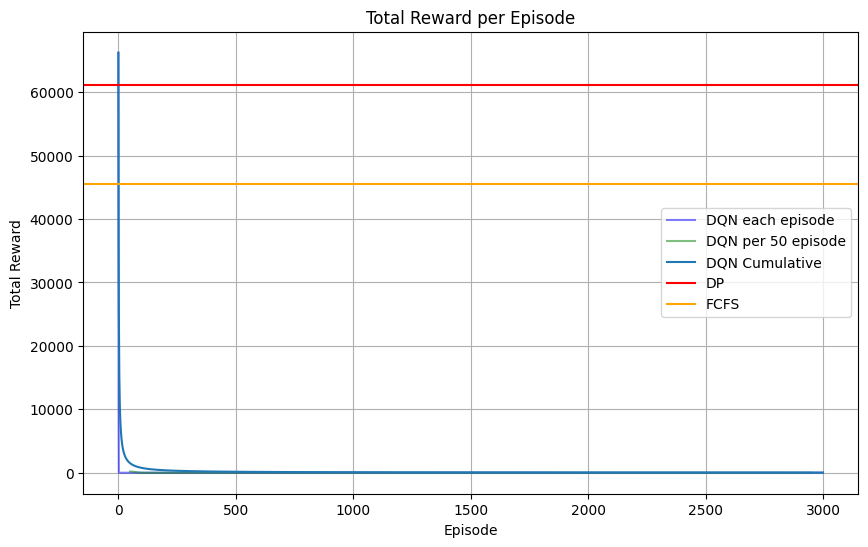

In [17]:
# Plot results
plt.figure(figsize=(10, 6))  
plt.plot(range(num_episodes), DQN_total_revenues, label='DQN each episode', alpha=0.5, color='b')
plt.plot(range(50, num_episodes, 50), DQN_per_50_avg, label='DQN per 50 episode', alpha=0.5, color='green')
plt.plot(range(num_episodes), DQN_cumulative_average, label='DQN Cumulative')
plt.axhline(y=dp, color='r', label='DP')
plt.axhline(y=fcfs, color='orange', label='FCFS')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()  
plt.grid(True)
plt.show()